In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import pandas as pd
import os

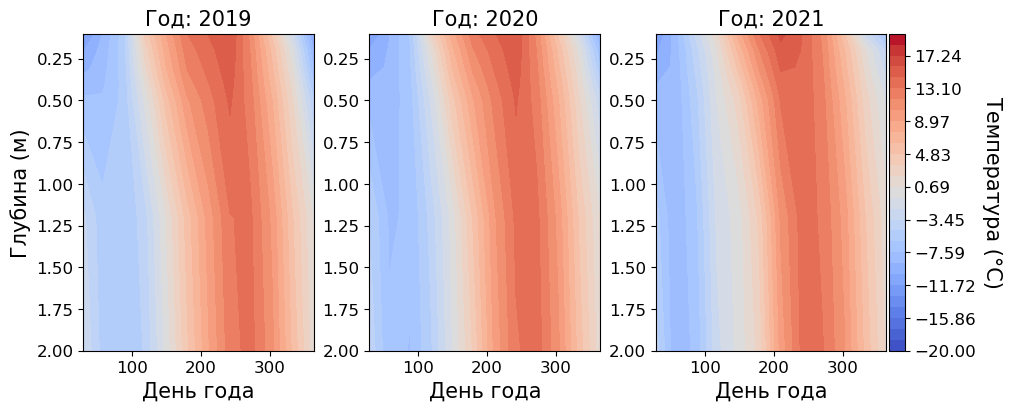

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the NetCDF file
file_path = 'output_scenario/tsl_monthly_bare.nc'
data = xr.open_dataset(file_path, decode_times=False)

# Define the depth of each soil layer based on the provided information
# Layers 1-4 are 10 cm, layers 5-6 are 80 cm each
layer_depths = [0.1] * 5 + [0.7, 0.8]  # in meters
cumulative_depths = np.cumsum(layer_depths)

# Get the soil temperature (tsl) and convert it from Kelvin to Celsius
soil_temp_kelvin = data['tsl'].values  # Assuming that the structure is [time, layer, lat, lon]
soil_temp_celsius = soil_temp_kelvin - 273.15

# Create a time variable that represents the day of the year for each time step
time_var = data['time'].values  # Time variable in days since 2018-12-31
start_date = np.datetime64('2018-12-31')  # Start date in the time variable
dates = start_date + np.timedelta64(1, 'D') * time_var  # Convert to actual dates
years = np.unique(dates.astype('datetime64[Y]'))  # Get unique years
years_to_plot = years[:3] if len(years) >= 3 else years  # Get first three years or fewer

# Mask for the time steps corresponding to the years we want to plot
mask_years = np.isin(dates.astype('datetime64[Y]'), years_to_plot)

# Filter the dates and temperatures for the years to plot
filtered_dates = dates[mask_years]
filtered_temps = soil_temp_celsius[mask_years, :, 0, 0]  # Assuming single lat/lon point

# Define the color levels based on the min and max temperatures
# temp_max = np.nanmax(soil_temp_celsius)
temp_max = 20
temp_min = -temp_max  # using nanmax to ignore NaNs if present
temp_levels = np.linspace(temp_min, temp_max, num=30)  # Define 20 levels between min and max

# Initialize the figure for plotting
fig, axs = plt.subplots(1, len(years_to_plot), figsize=(10, 4), constrained_layout=True)

# Plot for each selected year
for idx, year in enumerate(years_to_plot):
    # Extract data for the specific year
    year_mask = (dates.astype('datetime64[Y]') == year) & mask_years
    if np.any(year_mask):
        year_dates = dates[year_mask]
        year_days_of_year = (year_dates - year_dates.astype('datetime64[Y]')).astype(int)
        year_temps = soil_temp_celsius[year_mask, :, 0, 0]

        # Create a 2D grid for the x, y values
        X, Y = np.meshgrid(year_days_of_year, cumulative_depths)

        # Create contour plot for each year
        cp = axs[idx].contourf(X, Y, year_temps.T, levels=temp_levels, cmap='coolwarm')

        # Customize plot
        axs[idx].set_title(f'Год: {year}', fontsize = 15)
        axs[idx].set_xlabel('День года', fontsize = 15)
        axs[idx].invert_yaxis()  # Depth should increase downward
        axs[idx].tick_params(labelsize=12)
        if idx == 0:
            axs[idx].set_ylabel('Глубина (м)', fontsize = 15)

# Add colorbar to the last plot
cbar = fig.colorbar(cp, ax=axs[-1], pad=0.01)
cbar.ax.set_ylabel('Температура (°C)', rotation=270, va="bottom", fontsize = 15)
cbar.ax.tick_params(labelsize=12) 
# Show the plots
# plt.suptitle('Температурный профиль почвы. Результат моделирования CLASSIC')
plt.show()

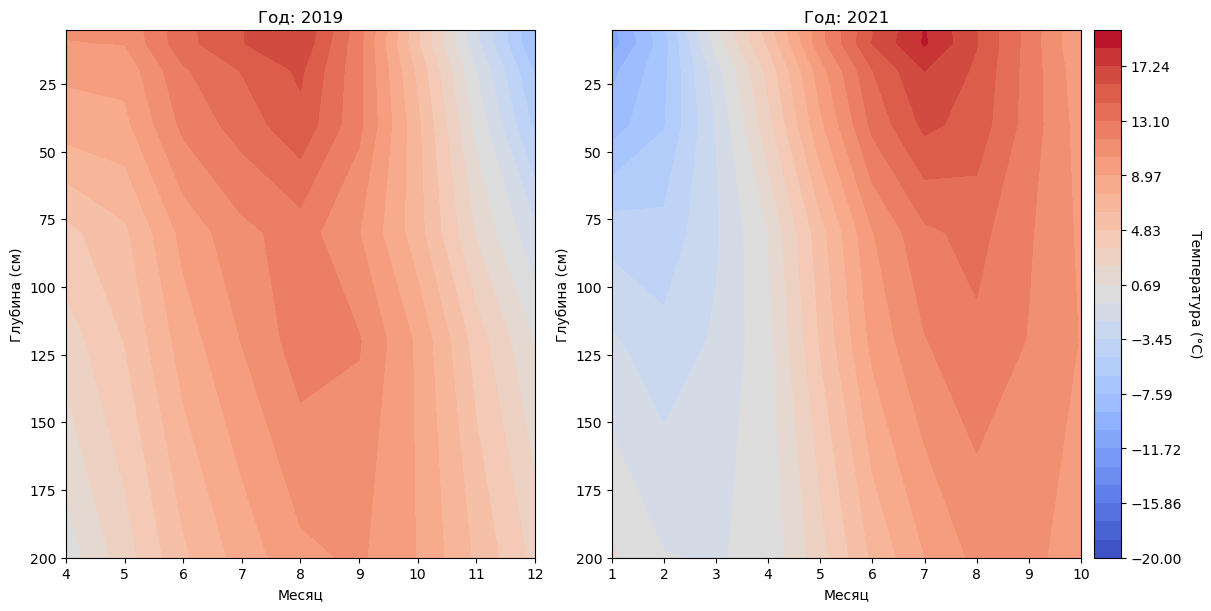

In [7]:
# Paths to the Excel files
file_path_2019 = '2019+Qinghai Lake basin observatory network+JJC+AWS.xlsx'
file_path_2021 = '2021+Qinghai Lake basin observatory network+JJC+AWS.xlsx'

# Read the Excel files
data_2019 = pd.read_excel(file_path_2019, skiprows=[1])
data_2021 = pd.read_excel(file_path_2021, skiprows=[1])

data_2019.replace(-6999, np.nan, inplace=True)
data_2021.replace(-6999, np.nan, inplace=True)

# Extract columns starting with 'Ts_' and ending with 'cm' (depth value)
ts_columns_2019 = [col for col in data_2019.columns if col.startswith('Ts_') and col.endswith('cm')]
ts_columns_2021 = [col for col in data_2021.columns if col.startswith('Ts_') and col.endswith('cm')]

# Resample the data if needed for easier plotting
# For example, resample to hourly data using the mean temperature
data_2019.set_index('TIMESTAMP', inplace=True)  # Replace 'Time' with the actual name of the time column
data_2021.set_index('TIMESTAMP', inplace=True)
data_2019_hourly = data_2019[ts_columns_2019].resample('ME').mean()
data_2021_hourly = data_2021[ts_columns_2021].resample('ME').mean()

temp_max = 20
temp_min = -temp_max  # using nanmax to ignore NaNs if present
temp_levels = np.linspace(temp_min, temp_max, num=30)

# Plotting similar to the previous plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
for idx, (year, data) in enumerate(zip([2019, 2021], [data_2019_hourly, data_2021_hourly])):
    # Only consider depths up to 2 meters (200 cm)
    cols_to_plot = [col for col in data.columns if int(col.split('_')[-1].replace('cm', '')) <= 200]
    depths = [int(col.split('_')[-1].replace('cm', '')) for col in cols_to_plot]
    times = data.index.month
    temperatures = data[cols_to_plot].values.T

    X, Y = np.meshgrid(times, depths)
    cp = axs[idx].contourf(X, Y, temperatures, vmin = -20, vmax = 20, cmap='coolwarm', levels=temp_levels)
    axs[idx].invert_yaxis()
    axs[idx].set_title(f'Год: {year}')
    axs[idx].set_ylabel('Глубина (см)')
    axs[idx].set_xlabel('Месяц')
# Add colorbar to the last plot
cbar = fig.colorbar(cp, ax=axs[-1], pad=0.01, )
cbar.ax.set_ylabel('Температура (°C)', rotation=270, va="bottom")

# plt.suptitle('Температурный профиль почв по данным измерения на метеостанции')
plt.show()

In [15]:
clay = xr.open_dataset('CL.nc').sel(lat = 37.37, lon = 101.19, method='nearest')
sand = xr.open_dataset('SA.nc').sel(lat = 37.37, lon = 101.19, method='nearest')
silt = xr.open_dataset('SI.nc').sel(lat = 37.37, lon = 101.19, method='nearest')
orgm = xr.open_dataset('SOM.nc').sel(lat = 37.37, lon = 101.19, method='nearest')

In [22]:
clay

<xarray.Dataset> Size: 72B
Dimensions:  (depth: 8)
Coordinates:
    lon      float32 4B 101.2
    lat      float32 4B 37.37
  * depth    (depth) float32 32B 4.5 9.1 16.6 28.9 49.3 82.9 138.3 229.6
Data variables:
    CL       (depth) float32 32B 11.8 11.68 10.7 11.23 14.71 14.46 20.33 nan
Attributes:
    Conventions:  CF-1.0

In [25]:
orgm.SOM.values

array([1.304 , 1.063 , 0.947 , 1.018 , 0.5923,    nan,    nan,    nan],
      dtype=float32)

In [16]:
clay.CL.values

array([11.8 , 11.68, 10.7 , 11.23, 14.71, 14.46, 20.33,   nan],
      dtype=float32)

In [23]:
sand.SA.values

array([47.55, 47.96, 50.49, 51.08, 46.22, 47.37, 35.38,   nan],
      dtype=float32)

In [24]:
silt.SI.values

array([40.65, 40.36, 38.8 , 37.69, 39.07, 38.17, 44.28,   nan],
      dtype=float32)

In [44]:
folder_path = "output_scenario/halfhourly"
file_paths = [f for f in os.listdir(folder_path)]
file_paths

['tsl_halfhourly_ND.nc',
 'tsl_halfhourly_MD.nc',
 'tsl_halfhourly_LD.nc',
 'tsl_halfhourly_HD.nc',
 'tsl_halfhourly_bare.nc']

In [56]:
def plot_all_layers_all_files(folder, file_paths):
    # Создание графиков для каждого слоя
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20), sharex=True)
    
    for layer_index in range(1, 8):  # 7 слоёв почвы
        ax = axes[layer_index-1]  # Получаем текущий axes
        for file_path in file_paths:
            # Чтение данных из файла
            ds = xr.open_dataset(folder+'/'+file_path, decode_times=False)
            tsl_data = ds['tsl']
            # Выборка данных для текущего слоя
            layer_data = tsl_data.sel(layer=layer_index)
            # Построение графика для текущего слоя и файла
            ax.plot(layer_data.time, layer_data.values.flatten(), label=file_path[:-3])
        
        # Настройка внешнего вида графиков
        ax.set_title(f'Почвенный горизонт №{layer_index}', fontsize = 15)
        ax.set_xlabel('Время')
        ax.set_ylabel('Температура почвы (K)', fontsize = 15)
        ax.legend(loc = 'upper left')

    # Показать графики
    plt.tight_layout()
    plt.show()

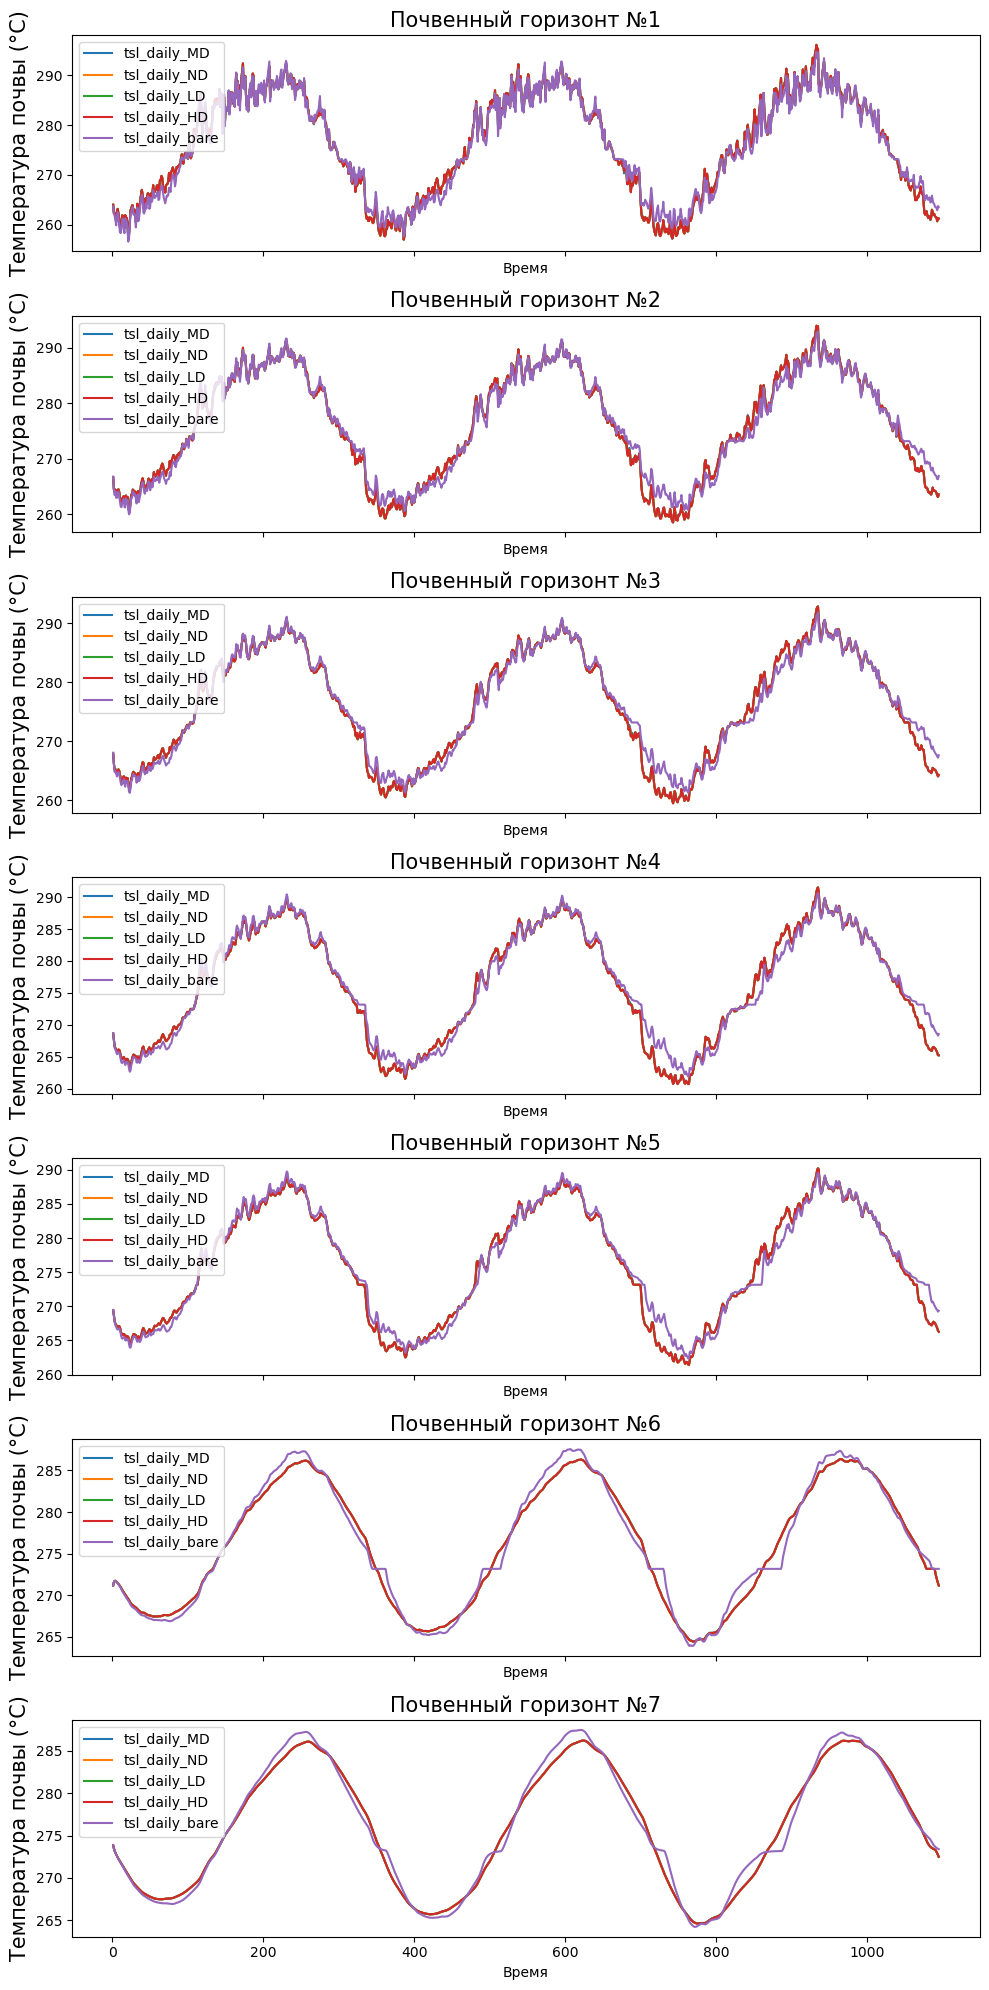

In [38]:
folder_path = "output_scenario/daily"
file_paths = [f for f in os.listdir(folder_path)]

plot_all_layers_all_files(folder_path, file_paths)

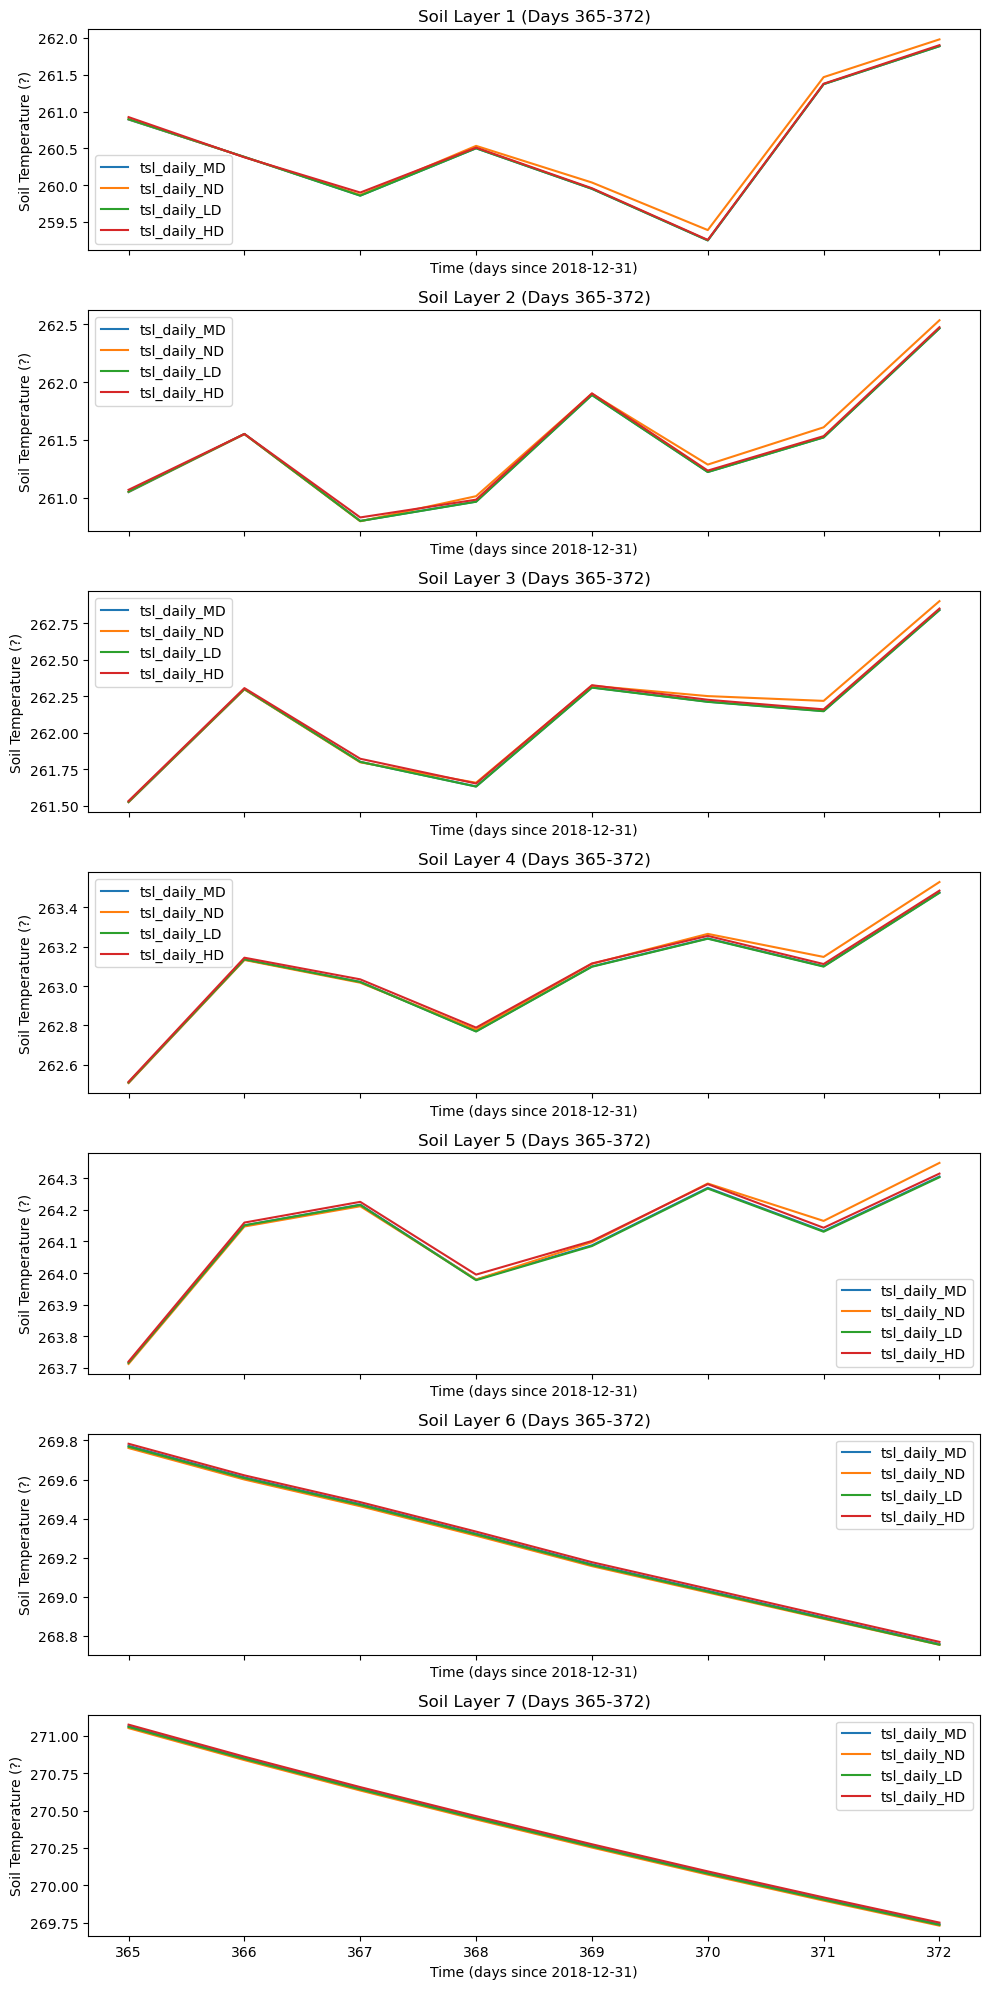

In [42]:
def plot_weekly_layers_all_files(file_paths, start_day, end_day):
    # Создание графиков для каждого слоя
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 20), sharex=True)
    
    for layer_index in range(1, 8):  # 7 слоёв почвы
        ax = axes[layer_index-1]  # Получаем текущий axes
        for file_path in file_paths:
            if file_path[-4] == "e":
                continue
            # Чтение данных из файла
            ds = xr.open_dataset(folder_path+"/"+file_path, decode_times=False)
            tsl_data = ds['tsl']
            # Выборка данных для текущего слоя в указанный период
            layer_data = tsl_data.sel(layer=layer_index).sel(time=slice(start_day, end_day))
            # Построение графика для текущего слоя и файла
            ax.plot(layer_data.time, layer_data.values.flatten(), label=file_path[:-3])
        
        # Настройка внешнего вида графиков
        ax.set_title(f'Soil Layer {layer_index} (Days {start_day}-{end_day})')
        ax.set_xlabel('Time (days since 2018-12-31)')
        ax.set_ylabel('Soil Temperature (?)')
        ax.legend()

    # Показать графики
    plt.tight_layout()
    plt.show()

# Выборка и визуализация данных за неделю (например, с 365 по 372 день после начальной даты)
plot_weekly_layers_all_files(file_paths, 365, 372)

In [49]:
file_paths = {
    'ND': 'output_scenario/daily/tsl_daily_ND.nc',
    'MD': 'output_scenario/daily/tsl_daily_MD.nc',
    'LD': 'output_scenario/daily/tsl_daily_LD.nc',
    'HD': 'output_scenario/daily/tsl_daily_HD.nc',
    'bare': 'output_scenario/daily/tsl_daily_bare.nc'
}


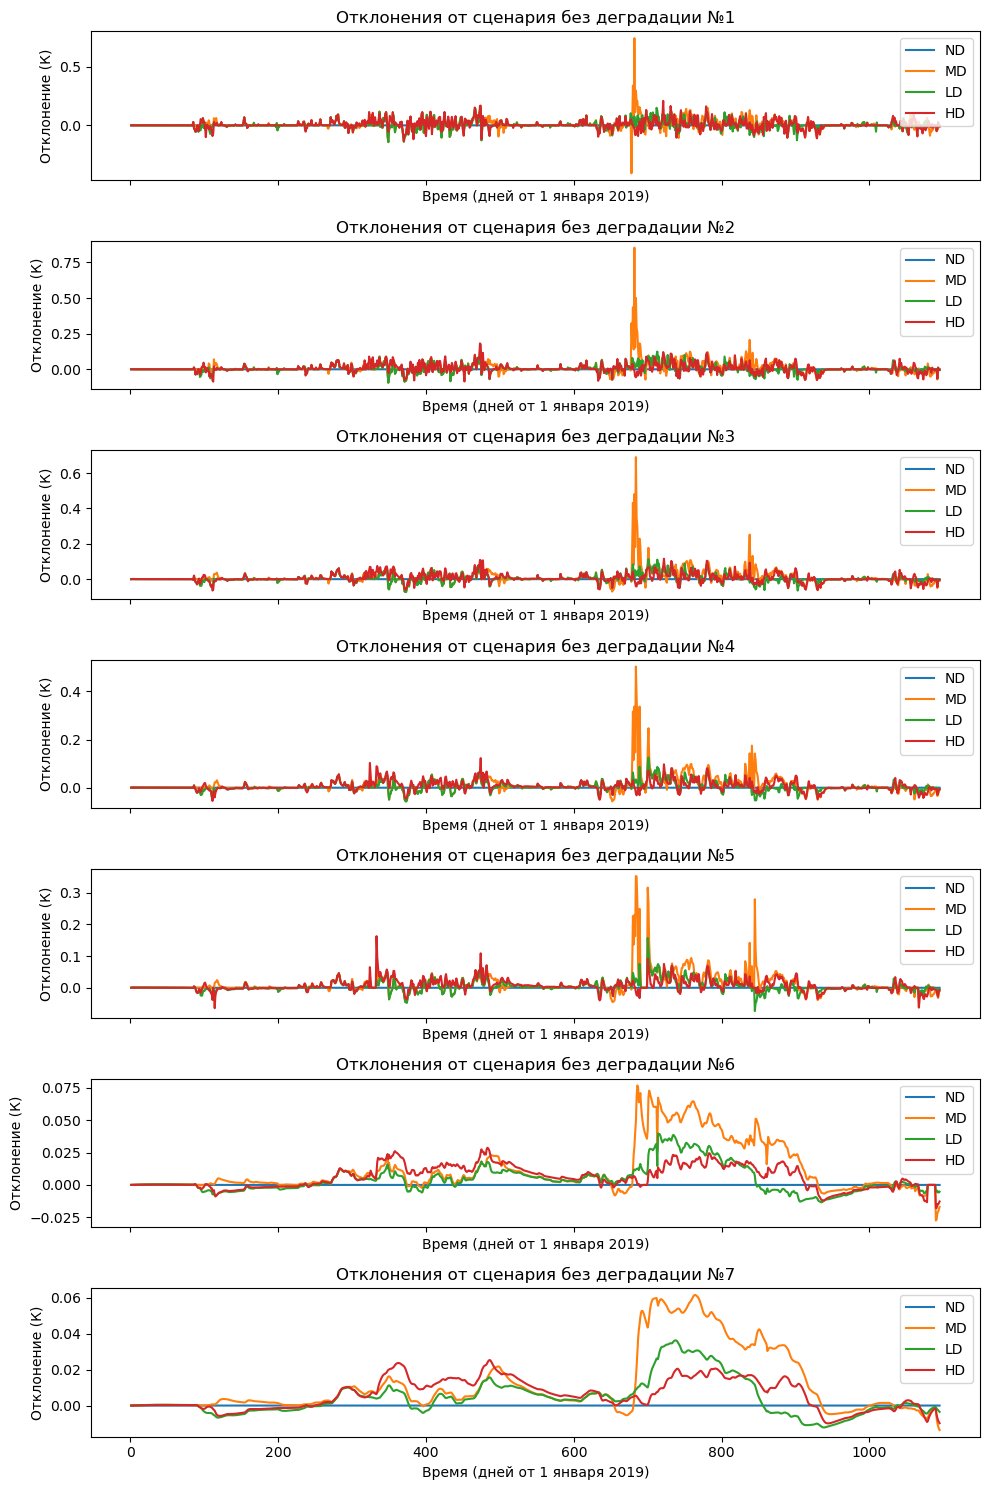

In [55]:
def plot_deviations_from_nd(file_paths_dict, exclude='bare'):
    # Создание графиков для каждого слоя
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 15), sharex=True)
    
    # Чтение данных для базового сценария (ND)
    base_ds = xr.open_dataset(next(iter(file_paths_dict.values())), decode_times=False)
    base_tsl = base_ds['tsl']
    
    for layer_index in range(1, 8):  # 7 слоёв почвы
        ax = axes[layer_index-1]  # Получаем текущий axes
        
        for label, file_path in file_paths_dict.items():
            if label != exclude:
                # Чтение данных из файла
                ds = xr.open_dataset(file_path, decode_times=False)
                tsl_data = ds['tsl']
                # Выборка данных для текущего слоя
                layer_data = tsl_data.sel(layer=layer_index)
                # Вычисление отклонения от базового сценария
                deviations = layer_data - base_tsl.sel(layer=layer_index)
                # Построение графика отклонений для текущего слоя и файла
                ax.plot(deviations.time, deviations.values.flatten(), label=label)
        
        # Настройка внешнего вида графиков
        ax.set_title(f'Отклонения от сценария без деградации №{layer_index}')
        ax.set_xlabel('Время (дней от 1 января 2019)')
        ax.set_ylabel('Отклонение (К)')
        ax.legend()

    # Показать графики
    plt.tight_layout()
    plt.show()

# Визуализация отклонений для всех слоёв, исключая 'bare'
plot_deviations_from_nd(file_paths, exclude='bare')